In [12]:
%load_ext watermark
%watermark -a "Romell D.Z." -u -d -p tweepy,scipy,nltk,gensim,sklearn,networkx,textblob,spacy

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Romell D.Z. 
last updated: 2019-08-25 

tweepy 3.6.0
scipy 1.1.0
nltk 3.2.5
gensim 3.4.0
sklearn 0.20.0
networkx 2.3
textblob 0.15.1
spacy 2.0.12


In [48]:
import os
import tweepy
from tweepy import Stream

import netrc

from unidecode import unidecode
import re

from tweepy import StreamListener

%matplotlib inline

from pprint import pprint
import pyprind
import pandas as pd

import random
from scipy.stats import beta as beta_distribution
import numpy as np

from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim  # don't skip this

from gensim.models.ldamodel import LdaModel
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from textblob import Word
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.simplefilter('ignore')

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import advertools as adv

import networkx as nx

import spacy
from spacy import displacy
nlp = spacy.load('es_core_news_sm')

In [3]:
auth = netrc.netrc()
ckey,_,csecret=auth.authenticators('tweet_api')
atoken,_,asecret=auth.authenticators('tweet_secret')

# [BoundingBox](https://boundingbox.klokantech.com/) CSV RAW

In [4]:
# LIMA_GEO_LOCATION_BOUNDING_BOX = [-77.1785277831,-12.1531578397,-76.8967618806,-11.9288928156]
LIMA_GEO_LOCATION_BOUNDING_BOX = [ -81.802362,-17.525482, -69.774343,-3.226278]
auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth)

In [5]:
NUMBER_OF_TWEETS = 1000
pbar = pyprind.ProgBar(NUMBER_OF_TWEETS)

In [6]:
class FiniteStreamListener(StreamListener):
    
    def __init__(self, number_of_tweets):
        self.number_of_tweets = number_of_tweets
        self.tweets = []
        self.tweets_dict = []
        super(FiniteStreamListener,self).__init__()
        
    def on_status(self, status):
        if len(self.tweets) < self.number_of_tweets:
            self.tweets_dict.append(status._json)
            place = status._json['place']['name'] if(status._json['place']) else ""
            self.tweets.append({'date':status.created_at,
                                'text':status.text,
                                'location':place,
                                'followers':status._json['user']['followers_count']})
            pbar.update()
        else:
            return False

In [7]:
finite_stream_listener = FiniteStreamListener(number_of_tweets=NUMBER_OF_TWEETS)
streaming_api = Stream(auth=auth, listener=finite_stream_listener,timeout=60)

### The streaming API doesn't allow to filter by location AND keyword simultaneously.

In [8]:
EMOTICONS = ">:] :-) :) :o) :] :3 :c) :> =] 8) =) :} :^) "
EMOTICONS = EMOTICONS.strip().split(' ')
# streaming_api.filter(track=EMOTICONS,async=True)
streaming_api.filter(locations=LIMA_GEO_LOCATION_BOUNDING_BOX,async=True)

In [12]:
print(len(finite_stream_listener.tweets))

56


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 01:05:42


In [13]:
np.save('tweets_dict',finite_stream_listener.tweets_dict)

In [17]:
def make_lowercase(tweet):
    return tweet.lower()

def remove_diacritics(tweet):
    return unidecode(tweet)

def remove_non_alpha_characters(tweet):
    return ''.join(character for character in tweet if character.isalpha() or character == ' ')

def remove_web_site(tweet):
    return re.sub(r'http\w+', '', tweet)#, flags=re.MULTILINE)

In [18]:
tweets_df = pd.DataFrame.from_dict(finite_stream_listener.tweets)
tweets_df.rename(columns={'text':'Tweets'},inplace=True)

In [19]:
tweets_df['word_count'] = tweets_df['Tweets'].apply(lambda x: len(str(x).split(" ")))
tweets_df['char_count'] = tweets_df['Tweets'].str.len()

def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

tweets_df['avg_word'] = tweets_df['Tweets'].apply(lambda x: avg_word(x))
tweets_df['hastags'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets_df['numerics'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [20]:
cleaned_tweets = list(tweets_df['Tweets'])
for cleaning_function in \
    [make_lowercase, 
#      remove_diacritics,
     remove_non_alpha_characters,
     remove_web_site]:
    cleaned_tweets = [cleaning_function(tweet) for tweet in cleaned_tweets]

In [21]:
random.sample(cleaned_tweets,5)

['ultima noche de semanademayordomia en la iasdesperanza aprendiendo sobre la importancia de ser fiel a dios con l ',
 'não existe boy legal em salvador asklgbt',
 'movistarvoleype vamos perú no podemos flaquear más adelante los equipos son más fuertes sabemos de su espíritu de lucha arriba perú',
 'noticiamerica tanto lío por ese pequeño lapsus',
 'pobre chica la cuerda siempre se rompe por el lado mas débil']

In [22]:
KEYWORD='lima'
number_of_occurences = sum(KEYWORD in tweet for tweet in cleaned_tweets)
print('Nuestra palabra clave aparece: {} veces'.format(number_of_occurences))
print('Nuestra palabra clave apareció en: {}% de los tweets'.format(100 * number_of_occurences/NUMBER_OF_TWEETS))

Nuestra palabra clave aparece: 41 veces
Nuestra palabra clave apareció en: 4.1% de los tweets


In [23]:
pprint([tweet for tweet in cleaned_tweets if KEYWORD in tweet][:5])

['cooking with fire in peru today cookingclass seerundo lima peru '
 'southamerica  lima peru ',
 'shopping for our cooking class today mercado seerundo lima peru '
 'southamerica  mercado n de surquillo ',
 'im at the beer place in lima  ',
 'im at centro cultural ricardo palma  munimiraflores in miraflores lima ',
 'estoy listo y esperándote barbon amado  una nueva jornada juntos hsmn '
 'octubremesmorado en sheraton lima hot ']


In [24]:
indices_of_tweets_containing_keyword=[index for index, tweet in enumerate(cleaned_tweets) if KEYWORD in tweet]
print('index de los 10 tweets:%s'%(indices_of_tweets_containing_keyword))

index de los 10 tweets:[6, 23, 103, 107, 116, 144, 149, 173, 211, 219, 237, 252, 254, 260, 277, 330, 373, 389, 392, 411, 421, 512, 522, 550, 653, 667, 684, 726, 727, 736, 743, 749, 821, 867, 877, 879, 884, 907, 912, 927, 969]


In [25]:
distances_between_indices_of_tweets_containing_keyword = [
    second_index - first_index for first_index, second_index in \
        zip(indices_of_tweets_containing_keyword[:-1], indices_of_tweets_containing_keyword[1:])
]

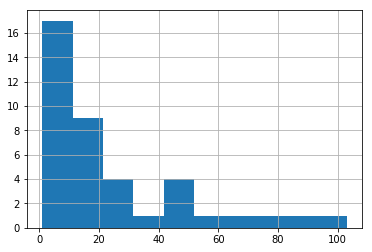

In [26]:
pd.Series(distances_between_indices_of_tweets_containing_keyword).hist()
plt.savefig('snapshot/lima_tweets_hist.png')

In [27]:
alpha = 1 + number_of_occurences
beta = 1 + (NUMBER_OF_TWEETS - number_of_occurences)

x_values = np.linspace(0, 1, 1002)[1:-1]
pdf_y_values = beta_distribution(alpha, beta).pdf(x_values)
cdf_y_values = np.cumsum(pdf_y_values) / np.sum(pdf_y_values)

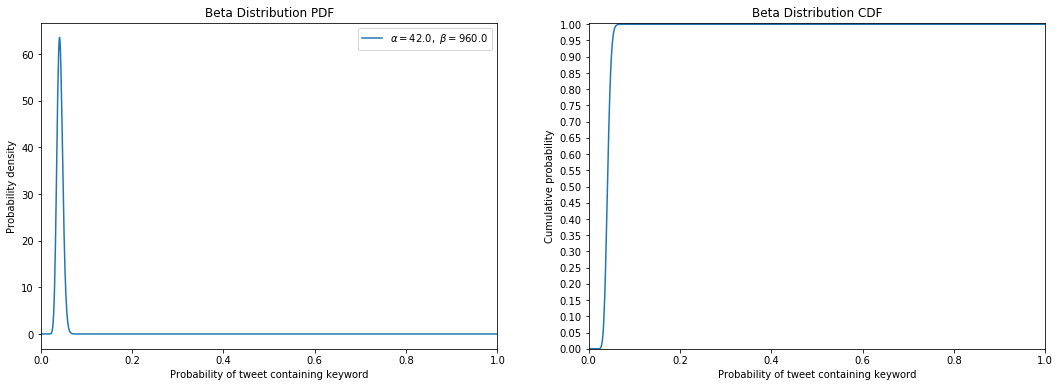

In [28]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(x_values, pdf_y_values, label=(r'$\alpha=%.1f,\ \beta=%.1f$' % (alpha, beta)))

plt.xlim(0, 1)
plt.xlabel('Probability of tweet containing keyword')
plt.ylabel('Probability density')
plt.title('Beta Distribution PDF')
plt.legend(loc=1)

plt.subplot(122)
plt.plot(x_values, cdf_y_values)
plt.xlim(0, 1)
plt.ylim(0, 1.005)
plt.yticks(np.linspace(0, 1, 21))
plt.xlabel('Probability of tweet containing keyword')
plt.ylabel('Cumulative probability')
plt.title('Beta Distribution CDF')
plt.savefig('snapshot/Beta Distribution CDF.png');

In [29]:
ix = [n for n,b in enumerate((cdf_y_values>.5)&(cdf_y_values<.95)) if b]

In [30]:
range_ =cdf_y_values[ix]

In [31]:
a=np.c_[x_values[ix],cdf_y_values[ix]]
max_ix,_ = np.unravel_index(a.argmax(), a.shape)
min_ix,_ = np.unravel_index(a.argmin(), a.shape)
fifth_percentile, ninety_fifth_percentile = x_values[max_ix],x_values[min_ix]

In [32]:
print('Con 90% de certeza digamos que la verdadera probabilidad se encuentra entre: {} y {}'.format(
    round(fifth_percentile, 10), round(ninety_fifth_percentile, 10)))

Con 90% de certeza digamos que la verdadera probabilidad se encuentra entre: 0.010989011 y 0.000999001


In [33]:
def compute_total_probability_that_probability_less_than_p(p):
    return max(cumulative_prob for cumulative_prob, x_value in zip(cdf_y_values, x_values) if x_value < p)

print('La probabilidad que la verdadera probabilidad es > .1 es: {}'.format(
    1 - compute_total_probability_that_probability_less_than_p(.1)))

La probabilidad que la verdadera probabilidad es > .1 es: 1.9441115384211116e-12


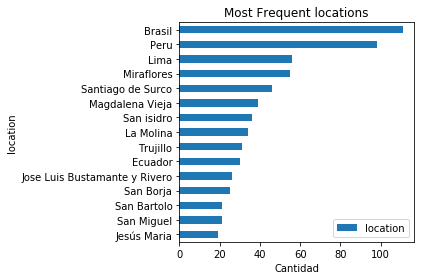

In [34]:
tweets_df.groupby('location').agg({'location':len}).sort_values('location').iloc[-15:].plot(kind='barh')
plt.title('Most Frequent locations')
plt.xlabel('Cantidad')
plt.tight_layout()
plt.savefig('snapshot/most Frequent locations.png');

In [35]:
tweets_df.to_csv('lima_tweets.csv',index=None)

In [36]:
tweets_df = pd.read_csv('lima_tweets.csv')

In [39]:
stop =stopwords.words('spanish') 

In [40]:
doc_complete = tweets_df.Tweets.values
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]   
tweets_df.dropna(inplace=True)

In [41]:
tweets_df['Tweets_clean'] = pd.Series(doc_clean).apply(lambda x:' '.join(x))
tweets_df['word_count'] = tweets_df['Tweets_clean'].apply(lambda x: len(str(x).split(" ")))
tweets_df['char_count'] = tweets_df['Tweets_clean'].str.len()

In [42]:
def avg_word(sentence):
    words = sentence.split()
    if len(words)==0:
        return 0
    return (sum(len(word) for word in words)/len(words))

tweets_df['avg_word'] = tweets_df['Tweets_clean'].apply(lambda x: avg_word(x))
tweets_df['hastags'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets_df['numerics'] = tweets_df['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweets_df.head()

,date,followers,location,Tweets,word_count,char_count,avg_word,hastags,numerics,Tweets_clean
0,2018-10-20 01:57:03,92,Lima,@elpanfletope @AlanGarciaPeru chancho no come ...,5,48,8.800000,0,0,elpanfletope alangarciaperu chancho come chancho
1,2018-10-20 01:57:10,32,Lince,@exitosape @JulianaOxenford A DONDE DICE ...,3,30,9.333333,0,0,exitosape julianaoxenford dice
2,2018-10-20 01:57:12,195,Brasil,@anajuliachs kkkk 1 mês,4,22,4.750000,0,1,anajuliachs kkkk 1 mês
3,2018-10-20 01:57:17,228,Chimbote,Ultima noche de #SemanaDeMayordomia en la @IAS...,11,105,8.636364,1,0,ultima noche semanademayordomia iasdesperanza ...
4,2018-10-20 01:57:18,123,San Miguel,@fernando_roman1 Jajaja,2,21,10.000000,0,0,fernandoroman1 jajaja


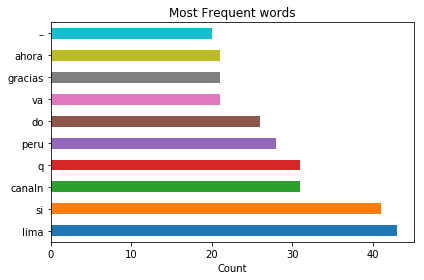

In [43]:
freq = pd.Series(' '.join(tweets_df['Tweets_clean']).split()).value_counts()[:10]
freq.plot(kind='barh')
plt.title('Most Frequent words')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig('snapshot/most Frequent words.png');

In [44]:
pprint(tweets_df['Tweets_clean'][:2])

0    elpanfletope alangarciaperu chancho come chancho
1                      exitosape julianaoxenford dice
Name: Tweets_clean, dtype: object


In [45]:
dictionary = corpora.Dictionary(tweets_df['Tweets_clean'].apply(lambda x:x.split()))

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [46]:
pprint(doc_term_matrix[:2])

[[(0, 1), (1, 2), (2, 1), (3, 1)], [(4, 1), (5, 1), (6, 1)]]


In [47]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [48]:
from pprint import pprint
pprint(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, '0.006*"peru" + 0.006*"lima" + 0.005*"–"'),
 (1, '0.004*"lima" + 0.004*"in" + 0.003*"fiscal"'),
 (2, '0.005*"si" + 0.003*"canaln" + 0.002*"amor"')]


In [49]:
# from gensim.test.utils import datapath
# fname = datapath("lda_lima_tweet_model")
ldamodel.save("lda_lima_tweet_model")

In [50]:
from gensim.models.ldamodel import LdaModel
ldamodel = LdaModel.load("lda_lima_tweet_model")

In [51]:
doc_lda = ldamodel[doc_term_matrix]

In [52]:
print('Perplexity: ', ldamodel.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better

Perplexity:  -8.825555626039103


In [53]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.102617  0.026479       1        1  34.787315
1      0.027390 -0.098442       2        1  32.855946
2      0.075227  0.071963       3        1  32.356747, topic_info=     Category       Freq                Term      Total  loglift  logprob
term                                                                     
34    Default  18.000000                peru  18.000000  30.0000  30.0000
2257  Default  13.000000                   –  13.000000  29.0000  29.0000
33    Default  27.000000                lima  27.000000  28.0000  28.0000
32    Default  12.000000                  in  12.000000  27.0000  27.0000
57    Default  10.000000              fiscal  10.000000  26.0000  26.0000
644   Default  12.000000                   é  12.000000  25.0000  25.0000
530   Default   6.000000                sabe   6.000000  24.0000  24.0000
570   Default   6.000000                josé   6.000000  23.0000  23.0000
455   Default   6.000000              quiero   6.000000  22.0000  22.0000
162   Default   7.000000                 san   7.000000  21.0000  21.0000
1727  Default   6.000000                 así   6.000000  20.0000  20.0000
779   Default   5.000000                  at   5.000000  19.0000  19.0000
887   Default   5.000000          mulderrctm   5.000000  18.0000  18.0000
658   Default   8.000000                amor   8.000000  17.0000  17.0000
1020  Default   4.000000                 dia   4.000000  16.0000  16.0000
23    Default   4.000000              jajaja   4.000000  15.0000  15.0000
2099  Default   4.000000               pérez   4.000000  14.0000  14.0000
2784  Default   4.000000       irvingtabares   4.000000  13.0000  13.0000
882   Default   4.000000               vamos   4.000000  12.0000  12.0000
2378  Default   4.000000            vizcarra   4.000000  11.0000  11.0000
537   Default   9.000000             domingo   9.000000  10.0000  10.0000
1767  Default   4.000000                 tal   4.000000   9.0000   9.0000
2081  Default   4.000000             viernes   4.000000   8.0000   8.0000
60    Default   4.000000           seguridad   4.000000   7.0000   7.0000
2376  Default   4.000000               patas   4.000000   6.0000   6.0000
2379  Default   4.000000              zacapa   4.000000   5.0000   5.0000
2370  Default   4.000000            almuerzo   4.000000   4.0000   4.0000
2377  Default   4.000000                 ron   4.000000   3.0000   3.0000
2371  Default   4.000000            borracho   4.000000   2.0000   2.0000
1327  Default   4.000000       abacojuridico   4.000000   1.0000   1.0000
...       ...        ...                 ...        ...      ...      ...
1291   Topic3   2.024631     movistarvoleype   2.437233   0.9429  -7.1358
1579   Topic3   2.024623              nombre   2.437234   0.9429  -7.1358
2753   Topic3   2.024604               bebés   2.437234   0.9429  -7.1358
2431   Topic3   2.024585                jaja   2.437234   0.9428  -7.1358
81     Topic3   2.024582        veromendozaf   2.437234   0.9428  -7.1358
425    Topic3   2.024570               pocos   2.437235   0.9428  -7.1358
540    Topic3   2.024568             prisión   2.437235   0.9428  -7.1358
82     Topic3   3.857558                caso   4.873332   0.8946  -6.4912
479    Topic3   3.860428                 vez   4.882683   0.8934  -6.4904
658    Topic3   6.305642                amor   8.558960   0.8228  -5.9997
1473   Topic3   3.247496             alguien   4.265806   0.8556  -6.6633
469    Topic3   3.896584               favor   5.495749   0.7845  -6.4811
416    Topic3  13.073942                  si  25.710005   0.4521  -5.2706
1556   Topic3   3.835145       keikofujimori   5.487342   0.7701  -6.4970
405    Topic3   4.463663               amigo   6.707940   0.7210  -6.3452
272    Topic3   5.111762                  em   8.561710   0.6126  -6.2096
80     Topic3   5.846062                 ver  10.382248   0.5

In [55]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc_ = nlp(sent)
        texts_out.append(list(set([str(c.head) for c in doc_ if c.head.tag_.startswith(tuple(allowed_postags))])))
    return texts_out

lemmatization(tweets_df['Tweets_clean'][:5],['VERB'])

[[], ['dice'], [], ['aprendiendo'], []]

In [56]:
def join_comma(row_list):
    if row_list == []:
        return np.NaN
    else:
        return ', '.join(row_list)

tweets_df['ACTIONS']=pd.Series(lemmatization(tweets_df['Tweets_clean'],['VERB'])).apply(join_comma)
tweets_df['NOUNS']=pd.Series(lemmatization(tweets_df['Tweets_clean'],['NOUN'])).apply(join_comma)

In [57]:
tweets_df[['Tweets_clean','NOUNS','ACTIONS']].head()

,Tweets_clean,NOUNS,ACTIONS
0,elpanfletope alangarciaperu chancho come chancho,elpanfletope,NaN
1,exitosape julianaoxenford dice,exitosape,dice
2,anajuliachs kkkk 1 mês,mês,NaN
3,ultima noche semanademayordomia iasdesperanza ...,noche,aprendiendo
4,fernandoroman1 jajaja,jajaja,NaN


In [58]:
tweets_df.head()

,date,followers,location,Tweets,word_count,char_count,avg_word,hastags,numerics,Tweets_clean,ACTIONS,NOUNS
0,2018-10-20 01:57:03,92,Lima,@elpanfletope @AlanGarciaPeru chancho no come ...,5,48,8.800000,0,0,elpanfletope alangarciaperu chancho come chancho,NaN,elpanfletope
1,2018-10-20 01:57:10,32,Lince,@exitosape @JulianaOxenford A DONDE DICE ...,3,30,9.333333,0,0,exitosape julianaoxenford dice,dice,exitosape
2,2018-10-20 01:57:12,195,Brasil,@anajuliachs kkkk 1 mês,4,22,4.750000,0,1,anajuliachs kkkk 1 mês,NaN,mês
3,2018-10-20 01:57:17,228,Chimbote,Ultima noche de #SemanaDeMayordomia en la @IAS...,11,105,8.636364,1,0,ultima noche semanademayordomia iasdesperanza ...,aprendiendo,noche
4,2018-10-20 01:57:18,123,San Miguel,@fernando_roman1 Jajaja,2,21,10.000000,0,0,fernandoroman1 jajaja,NaN,jajaja


In [59]:
tweets_df.to_csv('tweets_solutions.csv',index=None)

In [8]:
tweets_df = pd.read_csv('tweets_solutions.csv')
tweets_df.dropna(inplace=True)

In [9]:
tweets_df['Tweets_clean']

1                         exitosape julianaoxenford dice
3      ultima noche semanademayordomia iasdesperanza ...
6      cooking with fire in peru today cookingclass s...
7      show música vivo tecnópolis cierra temporada 2...
8                      maldita perra perdón alteré 💁🏻‍♀️
9      mininterperu pcmperu vizcarrhagan algo denle s...
10     🇪🇨🇪🇨quito ecuador 🇪🇨🇪🇨 vemos mañana eslae http...
11     sasha71396634 ernestojx hninurta gabospeed94 k...
12     ¡conoce proceso exhumación caso mascarilla com...
15     ronaldomendes triste fim da baleia bora fazer ...
17     mt colrichardkemp pt quinze mulheres disseram ...
19     kerch mourns victim of college massacre a surv...
21     pensar convento san francisco reposan restos f...
22     reaccionando ❌te puse perder ❌ javierramireze ...
23     shopping for our cooking class today mercado s...
26     acompañamos autores alvarobisama marcelo mella...
28     sturt0208 canaln martinvizcarrac arrugador fuj...
31     🎗️la prevención mejor tr

In [67]:
tweets_df['Tweets_clean'] = tweets_df['Tweets_clean'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
print(tweets_df.shape)
tweets_df['Tweets_clean'].head()

(523, 12)


1                       exitosape julianaoxenford dice
3    ultima noche semanademayordomia iasdesperanza ...
6    cooking with fire in peru today cookingclass s...
7    show música vivo tecnópolis cierra temporada 2...
8                    maldita perra perdón alteré 💁🏻‍♀️
Name: Tweets_clean, dtype: object

In [68]:
# displacy.serve(doc, style="dep")

In [74]:
doc = nlp(tweets_df['Tweets_clean'][1])
from IPython.display import HTML, Image, display
displacy.render(doc, style="dep",jupyter=True,options={'distance':100})

In [75]:
displacy.render(doc, style="ent",jupyter=True,)

In [69]:
TextBlob(tweets_df['Tweets_clean'][1]).ngrams(2)

[WordList(['exitosape', 'julianaoxenford']),
 WordList(['julianaoxenford', 'dice'])]

In [70]:
tf1 = (tweets_df['Tweets_clean']).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(tweets_df.shape[0]/(len(tweets_df[tweets_df['Tweets_clean'].str.contains(word)])))

tf1['tfidf'] = tf1['tf'] * tf1['idf']
print(tf1.shape)
tf1.head(10)

(3630, 4)


,words,tf,idf,tfidf
0,dice,7.0,3.774675,26.422724
1,julianaoxenford,1.0,6.259581,6.259581
2,exitosape,2.0,5.566434,11.132869
3,httpstcogmo19ienh6,1.0,6.259581,6.259581
4,iasdesperanza,1.0,6.259581,6.259581
5,l…,1.0,3.551531,3.551531
6,fiel,1.0,6.259581,6.259581
7,noche,3.0,4.873287,14.619861
8,semanademayordomia,1.0,6.259581,6.259581
9,dios,3.0,4.650144,13.950431


In [71]:
stop = set(stopwords.words('spanish'))
stop |= set(['lima','si','ser'])

In [72]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= stop,ngram_range=(1,1))
train_vect = tfidf.fit_transform(tweets_df['Tweets_clean'])
train_vect

<523x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2517 stored elements in Compressed Sparse Row format>

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(tweets_df['Tweets_clean'])
print(train_bow.shape)
train_bow

(523, 1000)


<523x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 2618 stored elements in Compressed Sparse Row format>

In [74]:
from sklearn.metrics.pairwise import linear_kernel

def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

In [81]:
tweet = tweets_df.sample(1)
tweet

,date,followers,location,Tweets,word_count,char_count,avg_word,hastags,numerics,Tweets_clean,ACTIONS,NOUNS
542,2018-10-20 02:32:30,159,Brasil,"@RogerioVilela @pauloap O problema é, quantos serão mortos???",7,53,6.714286,0,0,rogeriovilela pauloap problema é quantos serão mortos,serão,"problema, quantos"


In [82]:
print(tweet['Tweets'].values)

['@RogerioVilela @pauloap O problema é, quantos serão mortos???']


In [87]:
tweet.reset_index(drop=True,inplace=True)

In [89]:
pd.options.display.max_colwidth = 120
vals = pd.DataFrame()
for index, score in find_similar(train_vect, tweet.index[0],top_n = 5):
    vals = vals.append(tweets_df.iloc[index:index+1,:])
    vals.loc[index,'score'] = score
    
vals[['Tweets','score']].head()

,Tweets,score
845,@sigridbazan Se agranda mi admiración Sigrid. Lo dices porque lo dices.,NaN
440,NaN,0.565055
452,@exitosape \nNo sé qué es lo que sucede en #Exitosa que invitan a adefesios como ese seudoanalista politico de apell...,NaN
234,NaN,0.535451
900,"Para mí aquí siempre dice ""MI ALMA""",NaN


In [90]:
corpus = nlp('\n'.join(tweets_df['NOUNS'].dropna()))

In [91]:
visited = {}
nouns = []
for word in corpus:
    if word.pos_.startswith('N') and len(word.string) < 15 and len(word.string) > 2:
        token = word.string.strip().lower()
        if token in visited:
            visited[token] += 1
            continue
        else:
            visited[token] = 1
            nouns.append(word)
nouns = sorted(nouns, key=lambda w: -visited[w.string.strip().lower()])[:150]
pd.DataFrame([[w.text, visited[w.string.strip().lower()]] for w in nouns], columns=['Noun', 'Freq'])

,Noun,Freq
0,canaln,13
1,pra,6
2,gente,6
3,amor,6
4,patas,6
5,casa,5
6,franpetrozzi,5
7,juez,5
8,seguridad,4
9,caso,4


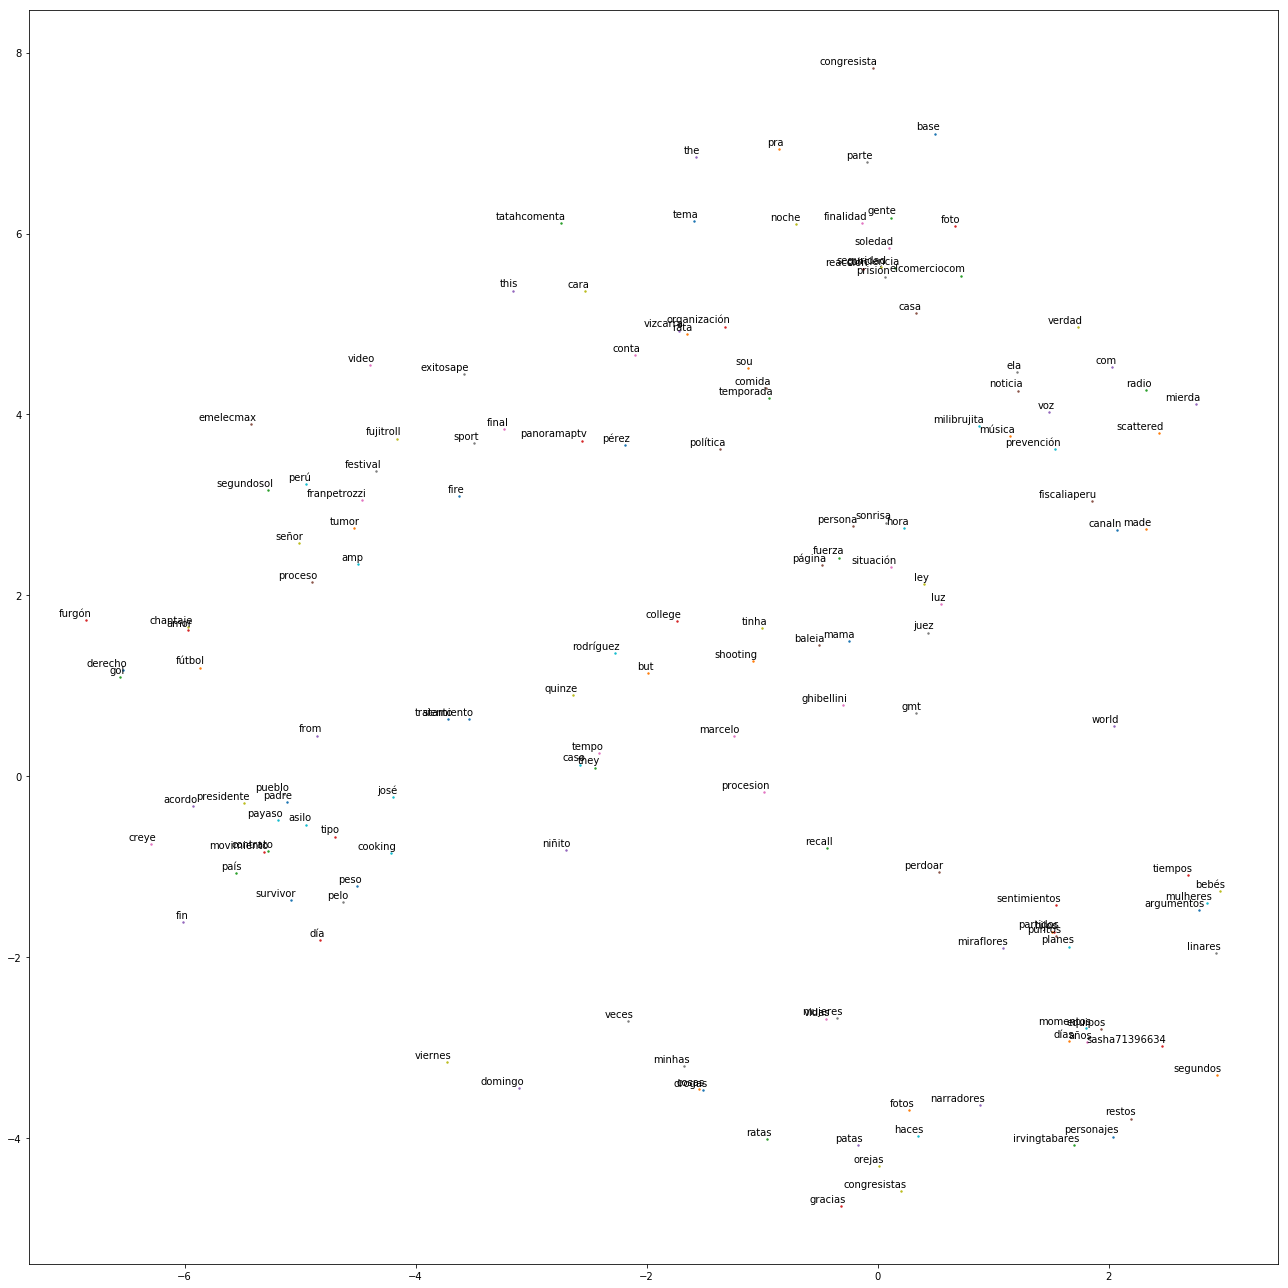

In [92]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y, s=2.0)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points',ha='right',va='bottom')
    plt.tight_layout()
    plt.savefig('snapshot/lima_words_TSNE.png')
    plt.show()

# Creating the tsne plot [Warning: will take time]
tsne = TSNE(perplexity=50.0, n_components=2, init='pca', n_iter=10000)

low_dim_embedding = tsne.fit_transform(np.array([word.vector for word in nouns]))

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, [word.text for word in nouns])

In [93]:
tweets_df = pd.read_csv('tweets_solutions.csv')
tweets_df.head(1)

,date,followers,location,Tweets,word_count,char_count,avg_word,hastags,numerics,Tweets_clean,ACTIONS,NOUNS
0,2018-10-20 01:57:03,92,Lima,@elpanfletope @AlanGarciaPeru chancho no come chancho,5,48,8.8,0,0,elpanfletope alangarciaperu chancho come chancho,NaN,elpanfletope


In [94]:
hashtag_summary = adv.extract_hashtags(tweets_df['Tweets'])
hashtag_summary.keys()

dict_keys(['hashtags', 'hashtags_flat', 'hashtag_counts', 'hashtag_freq', 'top_hashtags', 'overview'])

In [95]:
hashtag_summary['overview']

{'num_posts': 1000,
 'num_hashtags': 344,
 'hashtags_per_post': 0.344,
 'unique_hashtags': 238}

In [96]:
hashtag_summary['hashtags'][:20]

[[],
 [],
 [],
 ['#semanademayordomia'],
 [],
 [],
 ['#cookingclass', '#seerundo', '#lima', '#peru', '#southamerica'],
 [],
 [],
 [],
 ['#eslae'],
 [],
 ['#comprometidosconlaverdad', '#forensesec'],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [97]:
hashtag_summary['hashtag_counts'][:20]

[0, 0, 0, 1, 0, 0, 5, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0]

In [98]:
hashtag_summary['hashtag_freq'][:20]

[(0, 841),
 (1, 93),
 (2, 30),
 (3, 7),
 (4, 6),
 (5, 5),
 (6, 10),
 (7, 5),
 (8, 1),
 (9, 2)]

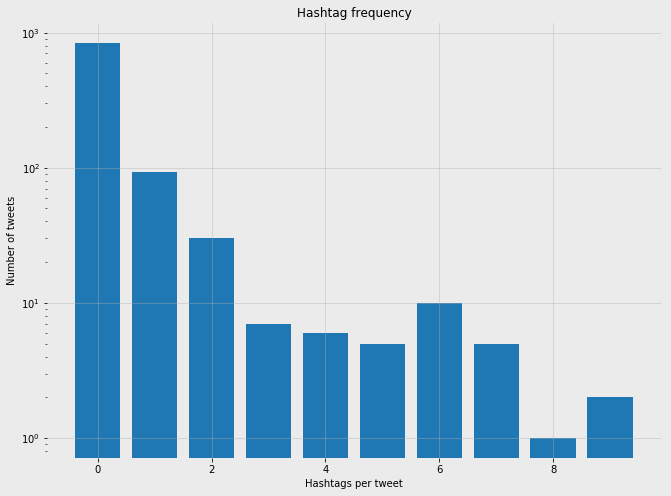

In [101]:
plt.figure(facecolor='#ebebeb', figsize=(11, 8))
plt.bar([x[0] for x in hashtag_summary['hashtag_freq'][:15]],
        [x[1] for x in hashtag_summary['hashtag_freq'][:15]])
plt.title('Hashtag frequency')
plt.xlabel('Hashtags per tweet')
plt.ylabel('Number of tweets')
plt.yscale('log')
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)

In [102]:
hashtag_summary['top_hashtags'][:10]

[('#lima', 9),
 ('#mulderrctm', 9),
 ('#22díasparaveracaché', 6),
 ('#cristomoreno', 6),
 ('#señordelosmilagros', 6),
 ('#elorigendelorigen', 5),
 ('#esviernesyyonecesito', 5),
 ('#mesmorado', 5),
 ('#turrondedoñapepa', 5),
 ('#anticuchos', 5)]

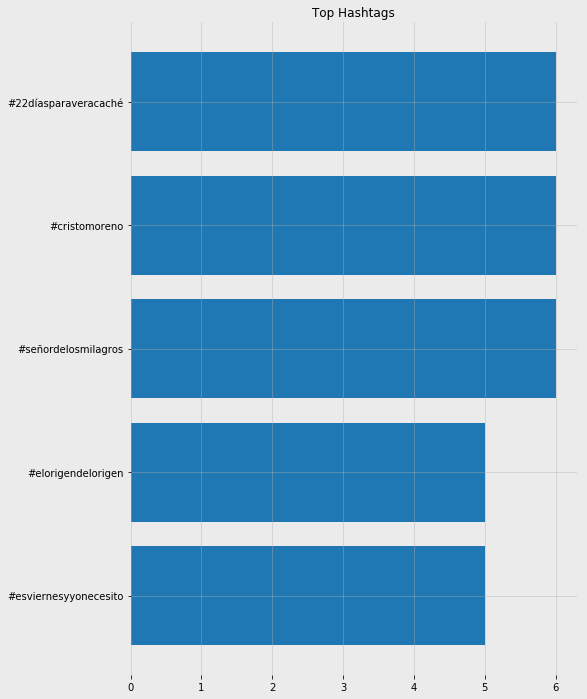

In [103]:
plt.figure(facecolor='#ebebeb', figsize=(8, 12))
plt.barh([x[0] for x in hashtag_summary['top_hashtags'][2:][:5]][::-1],
         [x[1] for x in hashtag_summary['top_hashtags'][2:][:5]][::-1])
plt.title('Top Hashtags')
# plt.xticks(range(3))
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)

In [104]:
emoji_summary = adv.extract_emoji(tweets_df['Tweets'])
emoji_summary.keys()

dict_keys(['emoji', 'emoji_text', 'emoji_flat', 'emoji_flat_text', 'emoji_counts', 'emoji_freq', 'top_emoji', 'top_emoji_text', 'overview'])

In [105]:
emoji_summary['overview']

{'num_posts': 1000,
 'num_emoji': 511,
 'emoji_per_post': 0.511,
 'unique_emoji': 132}

In [106]:
emoji_summary['emoji'][50:80]

[['📻', '📣'],
 [],
 [],
 [],
 [],
 [],
 ['🤔'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['😦'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['😀'],
 [],
 [],
 [],
 []]

In [107]:
emoji_summary['emoji_text'][50:80]

[['radio', 'megaphone'],
 [],
 [],
 [],
 [],
 [],
 ['thinking face'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['frowning face with open mouth'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['grinning face'],
 [],
 [],
 [],
 []]

In [108]:
emoji_summary['emoji_flat'][:10]

['💁🏻\u200d♀️', '🇪🇨', '🇪🇨', '🇪🇨', '🇪🇨', '🤔', '😆', '😆', '😆', '😆']

In [109]:
emoji_summary['emoji_flat_text'][:10]

['woman tipping hand light skin tone',
 'Ecuador',
 'Ecuador',
 'Ecuador',
 'Ecuador',
 'thinking face',
 'grinning squinting face',
 'grinning squinting face',
 'grinning squinting face',
 'grinning squinting face']

In [110]:
list(zip(emoji_summary['emoji_flat'][:10], emoji_summary['emoji_flat_text'][:10]))

[('💁🏻\u200d♀️', 'woman tipping hand light skin tone'),
 ('🇪🇨', 'Ecuador'),
 ('🇪🇨', 'Ecuador'),
 ('🇪🇨', 'Ecuador'),
 ('🇪🇨', 'Ecuador'),
 ('🤔', 'thinking face'),
 ('😆', 'grinning squinting face'),
 ('😆', 'grinning squinting face'),
 ('😆', 'grinning squinting face'),
 ('😆', 'grinning squinting face')]

In [111]:
emoji_summary['emoji_counts'][:15]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 1]

In [112]:
emoji_summary['emoji_freq'][:15]

[(0, 808),
 (1, 108),
 (2, 27),
 (3, 23),
 (4, 11),
 (5, 9),
 (6, 2),
 (8, 1),
 (9, 2),
 (10, 1),
 (11, 2),
 (13, 1),
 (15, 1),
 (18, 1),
 (23, 1)]

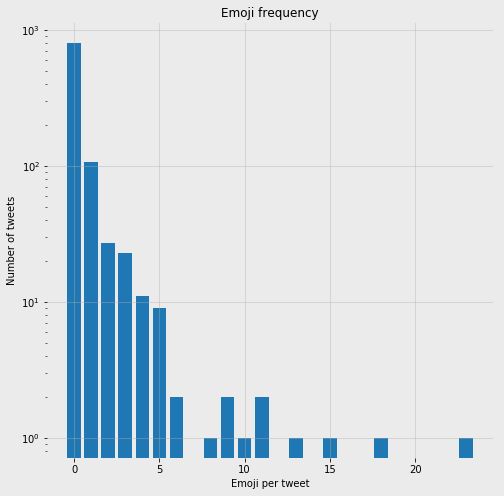

In [115]:
plt.figure(facecolor='#ebebeb', figsize=(8, 8))
plt.bar([x[0] for x in emoji_summary['emoji_freq'][:15]],
        [x[1] for x in emoji_summary['emoji_freq'][:15]])
plt.title('Emoji frequency')
plt.xlabel('Emoji per tweet')
plt.ylabel('Number of tweets')
plt.yscale('log')
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)

In [116]:
emoji_summary['top_emoji'][:8]

[('😭', 39),
 ('😂', 37),
 ('🤣', 32),
 ('❤', 21),
 ('♥', 20),
 ('😍', 17),
 ('🤤', 14),
 ('😻', 14)]

In [117]:
emoji_summary['top_emoji_text'][:8]

[('loudly crying face', 39),
 ('face with tears of joy', 37),
 ('rolling on the floor laughing', 32),
 ('red heart', 21),
 ('heart suit', 20),
 ('smiling face with heart-eyes', 17),
 ('drooling face', 14),
 ('smiling cat face with heart-eyes', 14)]

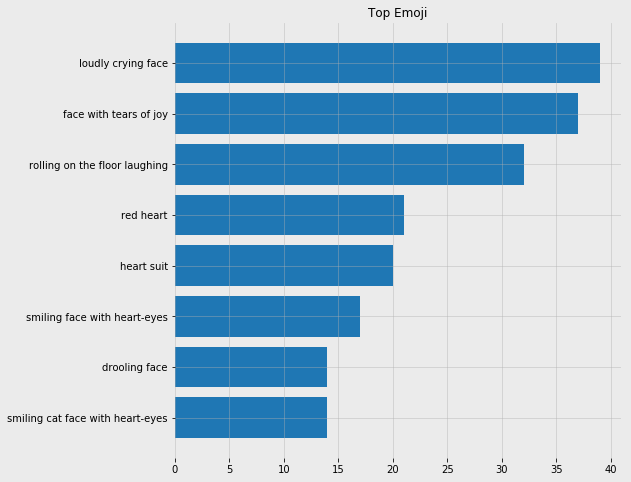

In [118]:
plt.figure(facecolor='#ebebeb', figsize=(8, 8))
plt.barh([x[0] for x in emoji_summary['top_emoji_text'][:8]][::-1],
         [x[1] for x in emoji_summary['top_emoji_text'][:8]][::-1])
plt.title('Top Emoji')
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)

In [119]:
mention_summary = adv.extract_mentions(tweets_df.Tweets)
mention_summary.keys()

dict_keys(['mentions', 'mentions_flat', 'mention_counts', 'mention_freq', 'top_mentions', 'overview'])

In [120]:
mention_summary['overview']

{'num_posts': 1000,
 'num_mentions': 886,
 'mentions_per_post': 0.886,
 'unique_mentions': 503}

In [121]:
mention_summary['mentions'][:15]

[['@elpanfletope', '@alangarciaperu'],
 ['@exitosape', '@julianaoxenford'],
 ['@anajuliachs'],
 ['@iasdesperanza'],
 ['@fernando_roman1'],
 [],
 [],
 [],
 [],
 ['@mininterperu', '@pcmperu', '@vizcarrhagan'],
 [],
 ['@sasha71396634',
  '@ernesto_jx',
  '@hninurta',
  '@gabospeed94',
  '@karla_ugaz',
  '@vero_mendoza_f'],
 [],
 [],
 []]

In [122]:
mention_summary['mentions_flat'][:10]

['@elpanfletope',
 '@alangarciaperu',
 '@exitosape',
 '@julianaoxenford',
 '@anajuliachs',
 '@iasdesperanza',
 '@fernando_roman1',
 '@mininterperu',
 '@pcmperu',
 '@vizcarrhagan']

In [123]:
mention_summary['mention_counts'][:20]

[2, 2, 1, 1, 1, 0, 0, 0, 0, 3, 0, 6, 0, 0, 0, 1, 1, 1, 0, 0]

In [124]:
mention_summary['mention_freq'][:15]

[(0, 484),
 (1, 341),
 (2, 105),
 (3, 29),
 (4, 11),
 (5, 6),
 (6, 4),
 (7, 10),
 (8, 10)]

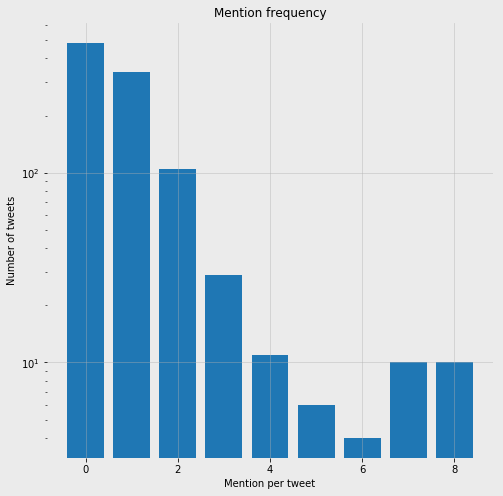

In [131]:
plt.figure(facecolor='#ebebeb', figsize=(8, 8))
plt.bar([x[0] for x in mention_summary['mention_freq'][:15]],
        [x[1] for x in mention_summary['mention_freq'][:15]])
plt.title('Mention frequency')
plt.xlabel('Mention per tweet')
plt.ylabel('Number of tweets')
plt.grid(alpha=0.5)
plt.yscale('log')
plt.gca().set_frame_on(False)
plt.savefig('snapshot/Mention Frequency.png');

In [132]:
mention_summary['top_mentions'][:10]

[('@canaln_', 31),
 ('@franpetrozzi', 11),
 ('@idl_r', 10),
 ('@rppnoticias', 10),
 ('@rosamariabartra', 9),
 ('@keikofujimori', 8),
 ('@ximena_casanova', 7),
 ('@policiaperu', 7),
 ('@milagrosleivag', 7),
 ('@abbu25', 7)]

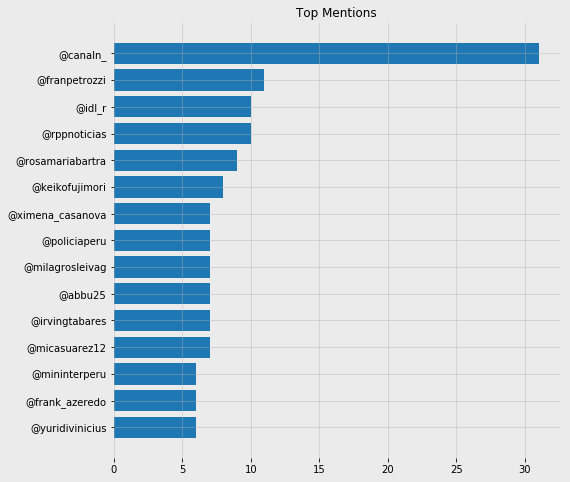

In [137]:
plt.figure(facecolor='#ebebeb', figsize=(8, 8))
plt.barh([x[0] for x in mention_summary['top_mentions'][:15]][::-1],
         [x[1] for x in mention_summary['top_mentions'][:15]][::-1])
plt.title('Top Mentions')
plt.grid(alpha=0.5)
plt.gca().set_frame_on(False)
plt.savefig('snapshot/Top Mentions.png');

In [138]:
tweets_df.columns

Index(['date', 'followers', 'location', 'Tweets', 'word_count', 'char_count',
       'avg_word', 'hastags', 'numerics', 'Tweets_clean', 'ACTIONS', 'NOUNS'],
      dtype='object')

In [139]:
extracted_tweets =  (tweets_df[['Tweets', 'followers']]
 .assign(hashtags=hashtag_summary['hashtags'],
         hashcounts=hashtag_summary['hashtag_counts'],
         mentions=mention_summary['mentions'],
         mention_count=mention_summary['mention_counts'],
         emoji=emoji_summary['emoji'],
         emoji_text=emoji_summary['emoji_text'],
         emoji_count=emoji_summary['emoji_counts'],))
extracted_tweets.head()

,Tweets,followers,hashtags,hashcounts,mentions,mention_count,emoji,emoji_text,emoji_count
0,@elpanfletope @AlanGarciaPeru chancho no come chancho,92,[],0,"[@elpanfletope, @alangarciaperu]",2,[],[],0
1,@exitosape @JulianaOxenford A DONDE DICE ...,32,[],0,"[@exitosape, @julianaoxenford]",2,[],[],0
2,@anajuliachs kkkk 1 mês,195,[],0,[@anajuliachs],1,[],[],0
3,"Ultima noche de #SemanaDeMayordomia en la @IASDEsperanza, aprendiendo sobre la importancia de ser fiel a Dios con l…...",228,[#semanademayordomia],1,[@iasdesperanza],1,[],[],0
4,@fernando_roman1 Jajaja,123,[],0,[@fernando_roman1],1,[],[],0


In [140]:
extracted_tweets.columns

Index(['Tweets', 'followers', 'hashtags', 'hashcounts', 'mentions',
       'mention_count', 'emoji', 'emoji_text', 'emoji_count'],
      dtype='object')

In [141]:
word_freq_hash = adv.word_frequency(extracted_tweets['hashtags'].str.join(' '), 
                                    extracted_tweets['followers'].fillna(0))#.sort_values(['abs_freq'], ascending=False).head(20)
word_freq_hash.head(10)

,word,abs_freq,wtd_freq,rel_value
0,#lima,9,430823,47869.0
1,#drogas,2,295632,147816.0
2,#microcomercializar,2,295632,147816.0
3,#chorrillos,1,147819,147819.0
4,#esviernesyyonecesito,5,147727,29545.0
5,#renuncia,1,107446,107446.0
6,#pérez,1,107446,107446.0
7,#tablitasexcel,2,92850,46425.0
8,#22díasparaveracaché,6,40669,6778.0
9,#burnthestagethemovieinvzla,1,39846,39846.0


In [142]:
extracted_tweets[extracted_tweets['hashtags'].str.join(' ')
                  .str.contains('lima',case=False)]

,Tweets,followers,hashtags,hashcounts,mentions,mention_count,emoji,emoji_text,emoji_count
6,"Cooking with fire in Peru today #cookingclass #seerundo #lima #peru #southamerica @ Lima, Peru https://t.co/llmzIMjMUo",13,"[#cookingclass, #seerundo, #lima, #peru, #southamerica]",5,[],0,[],[],0
23,Shopping for our cooking class today #mercado #seerundo #lima #peru #southamerica @ Mercado N#1 de Surquillo https:/...,13,"[#mercado, #seerundo, #lima, #peru, #southamerica, #1]",6,[],0,[],[],0
252,"Feels good to be back home 🇵🇪 #peru #larcomar #lima @ Lima, Peru https://t.co/agFso0gRcs",247,"[#peru, #larcomar, #lima]",3,[],0,[🇵🇪],[Peru],1
330,#esviernesyyonecesito es ahora una tendencia en #Lima\n\nhttps://t.co/UOmWB9sTSw https://t.co/oZBAUS7GPe,107446,"[#esviernesyyonecesito, #lima]",2,[],0,[],[],0
389,By @mariotestino 🙌🏼 \n.\n.\n.\n.\n.\n.\n.\n.\n#igersperu #lima #museum #musee #peru #mariotestino #photography #mode...,213,"[#igersperu, #lima, #museum, #musee, #peru, #mariotestino, #photography, #mode]",8,[@mariotestino],1,[🙌🏼],[raising hands medium-light skin tone],1
512,#pérez es ahora una tendencia en #Lima\n\nhttps://t.co/CXgZJw73Ty https://t.co/a7wfyKchQU,107446,"[#pérez, #lima]",2,[],0,[],[],0
653,Pequeña\n#traveler #explorer #flower #lima #pic #nice #photograpy https://t.co/82r1wgHu3w,553,"[#traveler, #explorer, #flower, #lima, #pic, #nice, #photograpy]",7,[],0,[],[],0
749,#renuncia es ahora una tendencia en #Lima\n\nhttps://t.co/DhxjeOKeix https://t.co/61jYXcNSwk,107446,"[#renuncia, #lima]",2,[],0,[],[],0
821,"'cerradura', 'desconocidos' y 'amedrentamiento' es ahora una tendencia en #Lima\n\nhttps://t.co/zpEunuSxrb https://t...",107446,[#lima],1,[],0,[],[],0


In [143]:
word_freq_mention = adv.word_frequency(extracted_tweets['mentions'].str.join(' '), 
                                       extracted_tweets['followers'].fillna(0))
                                    #.sort_values(['abs_freq'], ascending=False).head(20)
word_freq_mention.head(10)

,word,abs_freq,wtd_freq,rel_value
0,@gissellereyes,1,214460,214460.0
1,@ucatolicaec,3,52617,17539.0
2,@macara_oficial,1,46425,46425.0
3,@dcm_online,1,44161,44161.0
4,@brasil247,1,44161,44161.0
5,@terranoticiasbr,1,44160,44160.0
6,@canaln_,31,31715,1023.0
7,@jacquelinabravo,1,31299,31299.0
8,@alokadalis,2,27305,13652.0
9,@colrichardkemp,1,23611,23611.0


In [144]:
word_freq_emoji = adv.word_frequency(extracted_tweets['emoji'].str.join(' '), 
                                       extracted_tweets['followers'].fillna(0))#.sort_values(['abs_freq'], ascending=False).head(20)
word_freq_emoji.head(10)

,word,abs_freq,wtd_freq,rel_value
0,😭,39,434614,11144.0
1,🖤,1,377740,377740.0
2,🤔,7,304059,43437.0
3,📣,3,295880,98627.0
4,🚔,2,295632,147816.0
5,👮🏿‍♀️,2,295632,147816.0
6,👮🏿‍♂️,2,295632,147816.0
7,👉,7,221454,31636.0
8,😝,2,214546,107273.0
9,🇪🇨,4,153264,38316.0


In [145]:
[adv.emoji_dict.emoji_dict[k] for k in word_freq_emoji['word'][:10]]

[':loudly_crying_face:',
 ':black_heart:',
 ':thinking_face:',
 ':megaphone:',
 ':oncoming_police_car:',
 ':woman_police_officer_dark_skin_tone:',
 ':man_police_officer_dark_skin_tone:',
 ':backhand_index_pointing_right:',
 ':squinting_face_with_tongue:',
 ':Ecuador:']

In [146]:
word_freq_emoji[:10].assign(emoji_text=[adv.emoji_dict.emoji_dict[k] for k in word_freq_emoji['word'][:10]])

,word,abs_freq,wtd_freq,rel_value,emoji_text
0,😭,39,434614,11144.0,:loudly_crying_face:
1,🖤,1,377740,377740.0,:black_heart:
2,🤔,7,304059,43437.0,:thinking_face:
3,📣,3,295880,98627.0,:megaphone:
4,🚔,2,295632,147816.0,:oncoming_police_car:
5,👮🏿‍♀️,2,295632,147816.0,:woman_police_officer_dark_skin_tone:
6,👮🏿‍♂️,2,295632,147816.0,:man_police_officer_dark_skin_tone:
7,👉,7,221454,31636.0,:backhand_index_pointing_right:
8,😝,2,214546,107273.0,:squinting_face_with_tongue:
9,🇪🇨,4,153264,38316.0,:Ecuador:


In [147]:
sotu_retweets = np.load('tweets_dict.npy')

In [152]:
def buildDataFrameFromDict(mapping):
    df=[]
    for f in mapping:
        f_n = {}
        for k,item in f.items():
            if isinstance(item,dict):
                for i,j in item.items():
                    f_n[k+'-'+i] = j
            else:
                f_n[k] = f[k]
        df.append(f_n)
    
    df = pd.DataFrame(df)
    return df

sotu = buildDataFrameFromDict(sotu_retweets)
sotu.head()

,contributors,coordinates,coordinates-coordinates,coordinates-type,created_at,display_text_range,entities-hashtags,entities-media,entities-symbols,entities-urls,...,user-profile_text_color,user-profile_use_background_image,user-protected,user-screen_name,user-statuses_count,user-time_zone,user-translator_type,user-url,user-utc_offset,user-verified
0,None,NaN,NaN,NaN,Sat Oct 20 01:57:03 +0000 2018,"[30, 53]",[],NaN,[],[],...,333333,True,False,geriitx,293,None,none,https://m.facebook.com/geriita.ab?__user=1571199766,None,False
1,None,NaN,NaN,NaN,Sat Oct 20 01:57:10 +0000 2018,"[28, 44]",[],NaN,[],[],...,333333,True,False,MurgaRodolfo,256,None,none,None,None,False
2,None,NaN,NaN,NaN,Sat Oct 20 01:57:12 +0000 2018,"[13, 23]",[],NaN,[],[],...,333333,True,False,GusRodrigues4,752,None,none,None,None,False
3,None,NaN,NaN,NaN,Sat Oct 20 01:57:17 +0000 2018,"[0, 140]","[{'text': 'SemanaDeMayordomia', 'indices': [16, 35]}]",NaN,[],"[{'url': 'https://t.co/gMo19IEnh6', 'expanded_url': 'https://twitter.com/i/web/status/1053465144875991045', 'display...",...,333333,True,False,IASDEsperanza,698,None,none,None,None,False
4,None,NaN,NaN,NaN,Sat Oct 20 01:57:18 +0000 2018,"[17, 23]",[],NaN,[],[],...,333333,True,False,mcthuglife666,1168,None,none,None,None,False


In [156]:
for c in sotu.columns:
    print(c)

contributors
coordinates
coordinates-coordinates
coordinates-type
created_at
display_text_range
entities-hashtags
entities-media
entities-symbols
entities-urls
entities-user_mentions
extended_entities-media
extended_tweet-display_text_range
extended_tweet-entities
extended_tweet-extended_entities
extended_tweet-full_text
favorite_count
favorited
filter_level
geo
geo-coordinates
geo-type
id
id_str
in_reply_to_screen_name
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
is_quote_status
lang
place-attributes
place-bounding_box
place-country
place-country_code
place-full_name
place-id
place-name
place-place_type
place-url
possibly_sensitive
quote_count
quoted_status-contributors
quoted_status-coordinates
quoted_status-created_at
quoted_status-display_text_range
quoted_status-entities
quoted_status-extended_entities
quoted_status-extended_tweet
quoted_status-favorite_count
quoted_status-favorited
quoted_status-filter_level
quoted_status-geo
quoted_

In [159]:
data = sotu.sample(10)['user-screen_name']
sotu['retweeted_status-user-screen_name'] = np.random.choice(data,len(sotu))

In [162]:
sotu[['user-screen_name','retweeted_status-user-screen_name']].head()

,user-screen_name,retweeted_status-user-screen_name
0,geriitx,hhbacigalupo
1,MurgaRodolfo,hhbacigalupo
2,GusRodrigues4,mpauta
3,IASDEsperanza,hhbacigalupo
4,mcthuglife666,casidi13243


In [161]:
G_rt = nx.from_pandas_edgelist(
    sotu,
    source = 'user-screen_name', 
    target = 'retweeted_status-user-screen_name',
    create_using = nx.DiGraph())
    
print('Nodes in RT network:', len(G_rt.nodes()))
print('Edges in RT network:', len(G_rt.edges()))

Nodes in RT network: 505
Edges in RT network: 855


In [166]:
G_reply = nx.from_pandas_edgelist(
    sotu,
    source = 'user-screen_name', 
    target = 'in_reply_to_screen_name',
    create_using = nx.DiGraph())
    
print('Nodes in reply network:', len(G_reply.nodes()))

print('Edges in reply network:', len(G_reply.edges()))

Nodes in reply network: 796
Edges in reply network: 708


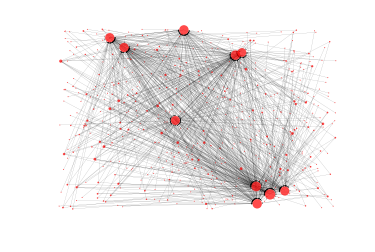

In [177]:
pos = nx.random_layout(G_rt)

sizes = [x[1] for x in G_rt.degree()]

nx.draw_networkx(G_rt, pos, 
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

plt.savefig('snapshot/lima_tweets_influencing_graph.png')
plt.axis('off'); plt.show()

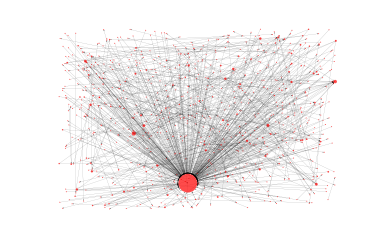

In [168]:
pos = nx.random_layout(G_reply)
sizes = [x[1] for x in G_reply.degree()]

nx.draw_networkx(G_reply, pos, 
    with_labels = False, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

plt.axis('off'); plt.show()

In [172]:
column_names = ['screen_name', 'degree_centrality']
rt_centrality = nx.in_degree_centrality(G_rt)

reply_centrality = nx.in_degree_centrality(G_reply)

rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)
reply = pd.DataFrame(list(reply_centrality.items()), columns = column_names)

display(rt.sort_values('degree_centrality', ascending = False).head())

display(reply.sort_values('degree_centrality', ascending = False).head())

,screen_name,degree_centrality
1,hhbacigalupo,0.208333
12,NOTIELMOMENTO,0.178571
7,casidi13243,0.176587
4,mpauta,0.174603
17,Rockmanita,0.168651


,screen_name,degree_centrality
7,None,0.441509
105,canalN_,0.015094
83,SolCn,0.005031
400,CesarNakazaki,0.005031
448,IDL_R,0.003774


In [171]:
column_names = ['screen_name', 'betweenness_centrality']
# Generate betweenness centrality for retweets 
rt_centrality = nx.betweenness_centrality(G_rt)

# Generate betweenness centrality for replies 
reply_centrality = nx.betweenness_centrality(G_reply)

# Store centralities in data frames
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)
reply = pd.DataFrame(list(reply_centrality.items()), columns = column_names)

# Print first five results in descending order of centrality
display(rt.sort_values('betweenness_centrality', ascending = False).head())

# Print first five results in descending order of centrality
display(reply.sort_values('betweenness_centrality', ascending = False).head())

,screen_name,betweenness_centrality
12,NOTIELMOMENTO,0.004589
27,FedericoClemen8,0.004563
10,marioporlavida,0.003482
17,Rockmanita,0.003354
1,hhbacigalupo,0.003119


,screen_name,betweenness_centrality
413,mindreaux,0.000003
442,famasem,0.000003
405,Ldavidesc,0.000002
0,geriitx,0.000000
526,rolo18al,0.000000


In [174]:
column_names = ['screen_name', 'degree']

degree_rt = pd.DataFrame(list(G_rt.in_degree()), columns = column_names)
degree_reply = pd.DataFrame(list(G_reply.in_degree()), columns = column_names)

ratio = degree_rt.merge(degree_reply, on = 'screen_name', suffixes = ('_rt', '_reply'))

ratio['ratio'] = ratio['degree_reply'] / ratio['degree_rt']

ratio = ratio[ratio['degree_rt'] >= 5]

display(ratio.sort_values('ratio', ascending = False).head())

,screen_name,degree_rt,degree_reply,ratio
1,hhbacigalupo,105,0,0.0
4,mpauta,88,0,0.0
7,casidi13243,89,0,0.0
10,marioporlavida,82,0,0.0
12,NOTIELMOMENTO,90,0,0.0
